(37500, 32, 32, 3) (37500, 10) (12500, 32, 32, 3) (12500, 10) (10000, 32, 32, 3) (10000, 10)


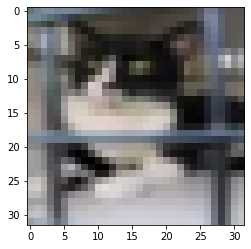

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] cat


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.datasets import cifar10 
from tensorflow.keras.utils import to_categorical
(train_images, train_labels), (x_test, y_test) = cifar10.load_data()


train_images = train_images.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0
train_labels = to_categorical(train_labels, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_images,train_labels,random_state=123)

print(x_train.shape,
      y_train.shape,
      x_val.shape,
      y_val.shape,
      x_test.shape,
      y_test.shape)

def labeling_vec(t):
    label_list = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]
    ll = np.arange(10)
    l = np.dot(t,ll)
    return label_list[int(l)]

k = 9
plt.imshow(x_train[k])
plt.show()
print(y_train[k],labeling_vec(y_train[k]))

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, layers, optimizers
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.models import Sequential, Model


# 使うGPU番号を指定(私の場合は5番を使用)
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"

# tensorflowは普通に使用すると、GPUメモリを取れるだけとってしまうため、最小限だけ使うように設定する。（命苫メソッド）
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Using TensorFlow backend.


In [4]:
#Making Models

def basic_conv_block(input, channel, shape, reps=1): ##sh畳み込み大きさ, reps回数
    x = input
    for i in range(reps):
        x = layers.Conv2D(channel,(shape,shape),padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
    return x

def create_cnn(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = basic_conv_block(input, 64, 5, reps=1)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 128, 3, reps=3)
    x = layers.AveragePooling2D(2)(x)
    x = basic_conv_block(x, 256, 3, reps=3)
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation('softmax')(x)

    model = Model(input, x)
    return model

################################

def STEM(input,channel):
    x = input
    x = layers.Conv2D(channel,(5,5),padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def downsampling(input,channel):
    x = input
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(channel,(3,3),padding="same",strides=2)(x)
    return x
# +conv 2回


def basic_conv_block_BN(input, channel, shape, reps=1): ##sh畳み込み大きさ, reps回数
    x = input
    for i in range(reps):
        x = layers.BatchNormalization()(x)
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(channel,(shape,shape),padding='same')(x)
    return x

def basic_conv_block_Dropout(input, channel, shape, reps=1): ##sh畳み込み大きさ, reps回数
    x = input
    for i in range(reps):
        x = layers.Dropout(0.4)(x)
        x = layers.Conv2D(channel,(shape,shape),padding='same')(x)
        x = layers.Activation("relu")(x)
    return x

def create_cnn_2(SHAPE,channel):
    input = Input(shape=(SHAPE,SHAPE,channel))
    x = STEM(input,32)
    x = layers.AveragePooling2D(2)(x)
    x = downsampling(x,64)
    x = basic_conv_block_BN(x, 64, 3, reps=2)
    #stage1
    #r = x 
    #x = basic_conv_block2(x,64,3,2)
    #x = layers.add([x,r])
    #x = layers.AveragePooling2D(2)(x)
    #stage2
    r = x 
    x = basic_conv_block_Dropout(x,128,3,reps=3)
    residual = layers.Conv2D(128,(1,1),padding='same')(r)
    x = layers.add([x,residual])
    x = layers.AveragePooling2D(2)(x)
    #stage3
    r = x
    x = basic_conv_block_Dropout(x, 256, 3, reps=3)
    residual = layers.Conv2D(256,(1,1),padding='same')(r)
    x = layers.add([x,residual])
    x = layers.GlobalAvgPool2D()(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(10)(x)
    x = layers.Activation('softmax')(x)

    model = Model(input, x)
    return model

In [8]:
#ensemble functions

from tensorflow.keras.callbacks import History, Callback
from keras.objectives import categorical_crossentropy
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from scipy.stats import mode
import os, pickle
import tensorflow.keras.backend as K

# 確率の平均を取るアンサンブル（ソフトアンサンブル）
def ensembling_soft(models, X):
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)
        else:
            preds_sum += model.predict(X)
    probs = preds_sum / len(models)
    return to_categorical(np.argmax(probs, axis=1), num_classes=10)

# 多数決のアンサンブル（ハードアンサンブル）
def ensembling_hard(models, X):
    pred_labels = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        pred_labels[:, i] = np.argmax(model.predict(X), axis=1)
    return to_categorical(mode(pred_labels, axis=1)[0], num_classes=10)

class Checkpoint(Callback):
    def __init__(self, model, filepath):
        self.model = model
        self.filepath = filepath
        self.best_val_acc = 0.0

    def on_epoch_end(self, epoch, logs):
        if self.best_val_acc < logs["val_acc"]:
            self.model.save_weights(self.filepath, save_format="h5")
            self.best_val_acc = logs["val_acc"]
            print("Weights saved.", self.best_val_acc)
            
from keras.callbacks import LearningRateScheduler

# 学習率
def step_decay(epoch):
    x = 0.0001
    warmup = 5
    if epoch < warmup:
        x *= (epoch+1)/warmup
    else:
        x *= (1 + np.cos(np.pi*(epoch+1-warmup)/EPOCHS))/2
    return x

#############################

In [22]:
def train_allmodel(x_train,y_train,x_val,y_val,vers,ensemble_type="both",n_estimators=5,batch_size=1024,EPOCHS = 100,model_type="cnn2"):
    assert ensemble_type in ["hard", "soft", "both"]
    assert model_type in ["cnn1", "cnn2"]
    n_estimators = n_estimators
    batch_size = 1024
    SHAPE = x_train.shape[1]
    channel = x_train.shape[3]
    
    models = []
    global_hist = {"hists":[], "ensemble_test":[]}
    single_preds = np.zeros((x_val.shape[0], n_estimators))
    for i in range(n_estimators):
        if model_type == "cnn2":
            train_model = create_cnn_2(SHAPE,channel)
        else:
            train_model = create_cnn(SHAPE,channel)
        train_model.compile(optimizer=optimizers.Adam(lr=1e-4), loss="categorical_crossentropy", metrics=["acc"])
        
        models.append(train_model)
        hist = History()
        cp = Checkpoint(train_model, f"weights{vers}_{i}.hdf5")
        csv_logger = CSVLogger('cf10_trlog_{}_{}'.format(vers,i), separator=',', append=False)
        early_stopping = EarlyStopping(monitor="val_acc", patience=30)
        learning_rate = LearningRateScheduler(step_decay,verbose=1)
        train_model.fit(x_train, y_train, batch_size=batch_size,
                        callbacks=[hist, cp, csv_logger, early_stopping, learning_rate],
                        validation_data=(x_val, y_val), epochs=EPOCHS)
        
        # 最良のモデルの読み込み
        train_model.load_weights(f"weights{vers}_{i}.hdf5")
        for layer in train_model.layers:
            layer.trainable = False

        # 単体の推論
        single_preds[:, i] = np.argmax(train_model.predict(x_val), axis=-1)

        # アンサンブルの精度の記録
        global_hist["hists"].append(hist.history)
        if ensemble_type == "soft":
            ensemble_test_pred = ensembling_soft(models, x_val)
        elif ensemble_type == "hard":
            ensemble_test_pred = ensembling_hard(models, x_val)
        else:
            ensemble_test_pred = ensembling_soft(models, x_val)
            ensemble_test_pred_h = ensembling_hard(models, x_val)
            ensemble_test_acc_h = accuracy_score(y_val, ensemble_test_pred_h)
        ensemble_test_acc = accuracy_score(y_val, ensemble_test_pred)

        global_hist["ensemble_test"].append(ensemble_test_acc)
        print("Current Ensemble validation Accuracy : ", ensemble_test_acc)

    global_hist["corrcoef"] = np.corrcoef(single_preds, rowvar=False)
    print("Corr Matrix on each estimators (Test)")
    print(global_hist["corrcoef"])

    with open(f"ensemble{vers}_{ensemble_type}.dat", "wb") as fp:
        pickle.dump(global_hist, fp)
    if ensemble_type == "both":
        return [ensemble_test_acc, ensemble_test_acc_h]
    else:
        return ensemble_test_acc
    
def ensembling_both(models, X, y):
    #soft ensemble
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)
        else:
            preds_sum += model.predict(X)
    probs = preds_sum / len(models)
    soft_ens_y_pred = to_categorical(np.argmax(probs, axis=1), num_classes=10)
    soft_ens_acc = accuracy_score(y, soft_ens_y_pred)
    #hard ensemble
    pred_labels = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        pred_labels[:, i] = np.argmax(model.predict(X), axis=1)
    hard_ens_y_pred = to_categorical(mode(pred_labels, axis=1)[0], num_classes=10)
    hard_ens_acc = accuracy_score(y, hard_ens_y_pred)
    return soft_ens_acc, hard_ens_acc

In [23]:
#Training Parameters
vers = 9
n_estimators = 5
batch_size = 1024
EPOCHS = 100


In [ ]:
K.clear_session()
ensemble_tests_acc = train_allmodel(x_train,
                                    y_train,
                                    x_val,
                                    y_val,
                                    vers,
                                    ensemble_type="both",
                                    n_estimators=n_estimators,
                                    batch_size=batch_size,
                                    EPOCHS=EPOCHS,
                                    model_type="cnn2")

Train on 37500 samples, validate on 12500 samples

Epoch 00001: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/100
37500/37500 [==============================] - 4s 106us/sample - loss: 2.4064 - acc: 0.1680 - val_loss: 2.3032 - val_acc: 0.1063

Epoch 00002: LearningRateScheduler setting learning rate to 4e-05.
Epoch 2/100
37500/37500 [==============================] - 3s 67us/sample - loss: 1.9585 - acc: 0.2924 - val_loss: 2.3056 - val_acc: 0.1240

Epoch 00003: LearningRateScheduler setting learning rate to 6e-05.
Epoch 3/100
37500/37500 [==============================] - 3s 70us/sample - loss: 1.7930 - acc: 0.3442 - val_loss: 2.3239 - val_acc: 0.1259

Epoch 00004: LearningRateScheduler setting learning rate to 8e-05.
Epoch 4/100
37500/37500 [==============================] - 2s 66us/sample - loss: 1.6820 - acc: 0.3798 - val_loss: 2.3561 - val_acc: 0.1015

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
Epoch 5/100
37500/37500 [=======================

In [25]:
for i in range(n_estimators):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    print('version:',vers,i,'best val score',np.max(log_data.val_acc))
print('version:',vers,'soft ensemble val accuracy:',ensemble_tests_acc[0])
print('version:',vers,'hard ensemble val accuracy:',ensemble_tests_acc[1])

version: 9 0 best val score 0.6854399999999999
version: 9 1 best val score 0.67128
version: 9 2 best val score 0.68152
version: 9 3 best val score 0.6708
version: 9 4 best val score 0.6654399999999999
version: 9 soft ensemble val accuracy: 0.73048
version: 9 hard ensemble val accuracy: 0.7248


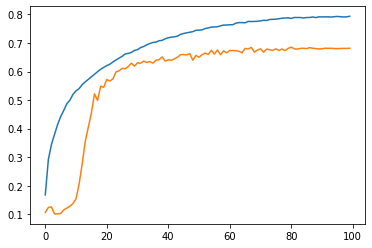

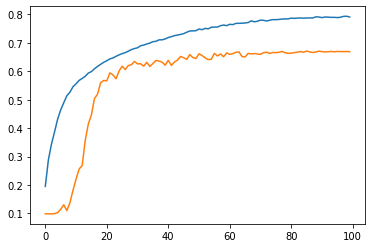

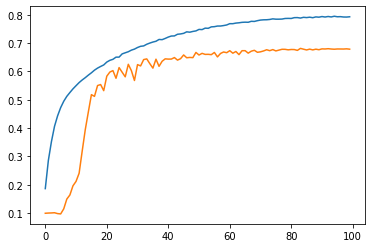

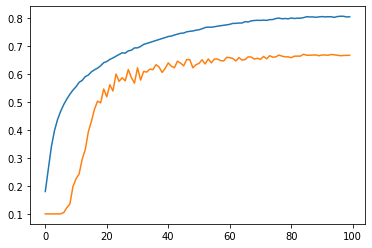

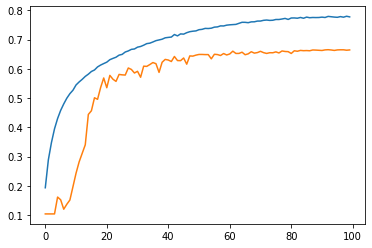

In [26]:
for i in range(n_estimators):
    log_data = pd.read_csv('cf10_trlog_{}_{}'.format(vers,i), sep=',', engine='python')
    plt.plot(log_data.acc)
    plt.plot(log_data.val_acc)
    plt.show()

In [27]:
#estimation
def load_allmodels(vers,num,SHAPE,channel):
    allmodels = []
    for i in range(num):
        train_model = create_cnn_2(SHAPE,channel)
        train_model.load_weights(f"weights{vers}_{i}.hdf5")
        for layer in train_model.layers:
            layer.trainable = False
        allmodels.append(train_model)
    return allmodels

allmodels = load_allmodels(vers,n_estimators,SHAPE,channel)
print("Soft/Hard ensemble",ensembling_both(allmodels,x_test,y_test))

Soft/Hard ensemble (0.7316, 0.7218)


In [28]:
#originals

#Square Soft ensemble
def ensembling_original(models, X, y):
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)**2
        else:
            preds_sum += model.predict(X)**2
    probs = preds_sum / len(models)
    ens_y_pred = to_categorical(np.argmax(probs, axis=1), num_classes=10)
    ens_acc = accuracy_score(y, ens_y_pred)
    return ens_acc

print(ensembling_original(allmodels,x_test,y_test))

0.7299


In [29]:
#Root Soft ensemble
#ルートをとって平均
def ensembling_original2(models, X, y):
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = np.sqrt(model.predict(X))
        else:
            preds_sum += np.sqrt(model.predict(X))
    probs = preds_sum / len(models)
    ens_y_pred = to_categorical(np.argmax(probs, axis=1), num_classes=10)
    ens_acc = accuracy_score(y, ens_y_pred)
    return ens_acc

print(ensembling_original2(allmodels,x_test,y_test))

0.7332


In [33]:
# N_square soft ensemble
def ensembling_original3(n, models, X, y):
    preds_sum = None
    for model in models:
        if preds_sum is None:
            preds_sum = model.predict(X)**n
        else:
            preds_sum += model.predict(X)**n
    probs = preds_sum / len(models)
    ens_y_pred = to_categorical(np.argmax(probs, axis=1), num_classes=10)
    ens_acc = accuracy_score(y, ens_y_pred)
    return ens_acc

for u in [0.0001, 0.001,0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8, 1, 2, 3, 4, 5]:
    print('**{}の平均:'.format(u),ensembling_original3(u,allmodels,x_test,y_test))

**0.0001の平均: 0.7337
**0.001の平均: 0.7338
**0.01の平均: 0.7338
**0.05の平均: 0.7336
**0.1の平均: 0.7343
**0.2の平均: 0.7342
**0.3の平均: 0.734
**0.5の平均: 0.7332
**0.8の平均: 0.7314
**1の平均: 0.7316
**2の平均: 0.7299
**3の平均: 0.7285
**4の平均: 0.7259
**5の平均: 0.7238


In [45]:
#T_Softmax Soft ensemble
#温度付きsoftmax関数
def get_interoutput(allmodels, x):
    intermediate_output = []
    for i in range(len(allmodels)):
        model = allmodels[i]
        layer_name = model.layers[-2].name
        intermediate_layer_model = Model(inputs=model.input,
                                         outputs=model.get_layer(layer_name).output)
        intermediate_output.append(intermediate_layer_model.predict(x))
    return intermediate_output

def ensembling_original4(T, intermediate_output, X, y):
    preds_sum = None
    for pred in intermediate_output:
        if preds_sum is None:
            preds_sum = K.softmax(pred/T)
        else:
            preds_sum += K.softmax(pred/T)
    probs = preds_sum / len(intermediate_output)
    ens_y_pred = to_categorical(np.argmax(probs, axis=1), num_classes=10)
    ens_acc = accuracy_score(y, ens_y_pred)
    return ens_acc

intermediate_output = get_interoutput(allmodels, x_test)

for i in [0.2,0.5,0.8,1.0,2.0,5.0,8.0,10,12,15,20]:
    print('T = ',i,'acc', ensembling_original4(i,intermediate_output,x_test,y_test))

T =  0.2 acc 0.7278
T =  0.5 acc 0.7309
T =  0.8 acc 0.7308
T =  1.0 acc 0.7307
T =  2.0 acc 0.7314
T =  5.0 acc 0.7318
T =  8.0 acc 0.7318
T =  10 acc 0.7318
T =  12 acc 0.7317
T =  15 acc 0.7316
T =  20 acc 0.7316


In [ ]:
# print('soft, hard:',ensembling_both(allmodels,x_val,y_val),'\n **2の平均:',ensembling_original(allmodels,x_val,y_val),'\n sqrtの平均',ensembling_original2(allmodels,x_val,y_val))